# GT Labels of Radiologists analysis

Nanyan "Rosalie" Zhu and Chen "Raphael" Liu

**Intuition**: We want a high sensitivity model and don't want to confuse our model, so we decide to train it on one of those 4 GTs provided by 4 radiologists, which has highest sensitivity.

$(1)$ Ensure that file folders covered all the nodule studies in LUNA. 

$(2)$ Use ground truth tif to bulid 3D nodule masks and see what is all the labels and radias in LUNA look like.

$(3)$ Calculate their connected componants and test if center of nudules accepted by LUNA16 are in their connected componants.

$(4)$ Analyze the result we got and decide which radiologist's labels we want to use.

**Note**: GT (gt): Ground Truth

### Read mapping csv file

In [2]:
import csv
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
from pydicom.data import get_testdata_files
from glob import glob as glob
import cv2 as cv
import SimpleITK as sitk
import csv
from PIL import Image
import ipyvolume as ipv
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Part 1: IDmapping and gt labels visualization

In [10]:
IDmapping_path = '/home/raphael/Projects/DL-Lung_Nodule_LUNA16/Datasets/LIDC_IDmapping/'

In [11]:
IDmapping = pd.read_csv(IDmapping_path + 'IDmapping.csv')
IDmapping.head()

studyID_all                    seriesID_all
0  584233139051825667176600857752  340202188094259402036602717327
1  339170810277323131167631068432  303494235102183795724852353824
2  303241414168367763244410429787  131939324905446238286154504249
3  303921580531000844896433537490  213233719488315954975724605159
4  584233139051825667176600857752  340202188094259402036602717327

**Drop redundant lines**

In [12]:
# Check the correct dimension first
len(IDmapping['studyID_all']), len(np.unique(IDmapping['studyID_all'])),\
len(IDmapping['seriesID_all']), len(np.unique(IDmapping['seriesID_all']))

(1319, 1294, 1319, 1294)

In [13]:
# Drop lines
IDmapping_clean = IDmapping.drop_duplicates('studyID_all', 'first', False)
IDmapping_clean.shape

(1294, 2)

### Read annotation

In [15]:
# read annotation 
# annotation_path = '/home/raphael/Projects/DL-Lung_Nodule_LUNA16/Datasets/LUNA16_dataset/annotations.csv'
annotation_path = '/home/raphael/Projects/DL-Lung_Nodule_LUNA16/Datasets/LUNA_annotation/annotations.csv'
annotation = pd.read_csv(annotation_path)

In [16]:
annotation.head()

seriesuid      coordX      coordY  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -128.699421 -175.319272   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  103.783651 -211.925149   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...   69.639017 -140.944586   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...  -24.013824  192.102405   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...    2.441547  172.464881   

       coordZ  diameter_mm  
0 -298.387506     5.651471  
1 -227.121250     4.224708  
2  876.374496     5.786348  
3 -391.081276     8.143262  
4 -405.493732    18.545150

**Add header**

In [17]:
if len(IDmapping_clean['seriesID_all'][1]) > 30:
    IDmapping_clean['seriesID_all'] = IDmapping_clean['seriesID_all'].str.replace('1.3.6.1.4.1.14519.5.2.1.6279.6001.','')
IDmapping_clean['seriesID_all'] = '1.3.6.1.4.1.14519.5.2.1.6279.6001.' + IDmapping_clean['seriesID_all']
IDmapping_clean.head()

studyID_all  \
0  584233139051825667176600857752   
1  339170810277323131167631068432   
2  303241414168367763244410429787   
3  303921580531000844896433537490   
5  924939006160714533549353726515   

                                        seriesID_all  
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.340202188094...  
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.303494235102...  
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.131939324905...  
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.213233719488...  
5  1.3.6.1.4.1.14519.5.2.1.6279.6001.311102747717...

In [18]:
annotation['studyID'] = [np.array(IDmapping_clean['studyID_all']\
                         [IDmapping_clean['seriesID_all'] == annotation['seriesuid'][i]])[0] \
                         for i in range(len(annotation['seriesuid']))]
annotation.head()

seriesuid      coordX      coordY  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -128.699421 -175.319272   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  103.783651 -211.925149   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...   69.639017 -140.944586   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...  -24.013824  192.102405   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...    2.441547  172.464881   

       coordZ  diameter_mm                         studyID  
0 -298.387506     5.651471  281499745765120562304307889347  
1 -227.121250     4.224708  281499745765120562304307889347  
2  876.374496     5.786348  139110171863263699469684411692  
3 -391.081276     8.143262  233360976397162618015897824056  
4 -405.493732    18.545150  233360976397162618015897824056

In [19]:
# number of patients in LUNA16 dataset who have nodules
len(np.unique(annotation['studyID']))

601

In [22]:
# check if all the study we want are in the gts

gt_path = '/home/raphael/Projects/DL-Lung_Nodule_LUNA16/Solutions/LungAndNoduleMasks/2DNoduleMasks/output-XML/gts/' #<---
studyID_list = os.listdir(gt_path)
not_found_count = 0
for study in annotation['studyID']:
    if len(np.where(studyID_list == study)) ==0:
        print('studyID', study, 'didn\'t find')
        not_found_count += 1
print('Done!', not_found_count, 'studyIDs are not found')
            

Done! 0 studyIDs are not found


In [23]:
def plot_boundary(image, threshold = 100, maxvalue = 255, minvalue = 0): 
    if len(np.shape(image)) == 3:
        _, thresh = cv.threshold(image[:,:,0], threshold, maxvalue, minvalue)
    elif len(np.shape(image)) == 2:
        _, thresh = cv.threshold(image, threshold, maxvalue, minvalue)
        
    else:
        np.error('wrong image dimension')
    
    thresh = np.uint8(thresh)
    _, contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    if np.shape(contours)[0] == 0:
        contours = np.zeros([2,2])
    
    contours = np.squeeze(contours)
    return(contours)

## Now upload sample scan can show all the labels of radiologies

In [24]:
def load_itk_image(filename):
    itkimage = sitk.ReadImage(filename)
    numpyImage = sitk.GetArrayFromImage(itkimage)
     
    numpyOrigin = np.array(list(reversed(itkimage.GetOrigin())))
    numpySpacing = np.array(list(reversed(itkimage.GetSpacing())))
     
    return numpyImage, numpyOrigin, numpySpacing

def readCSV(filename):
    lines = []
    with open(filename, "r") as f:
        csvreader = csv.reader(f)
        for line in csvreader:
            lines.append(line)
    return lines

def worldToVoxelCoord(worldCoord, origin, spacing):   
    stretchedVoxelCoord = np.absolute(worldCoord - origin)
    voxelCoord = stretchedVoxelCoord / spacing
    return voxelCoord


### Load ground truth for sample scan and find the nodule annotation method in LUNA

In [31]:
def plot_label(seriesID):   # Example seriesID: '964952370561266624992539111877'
    studyID = IDmapping_clean['studyID_all'][IDmapping_clean['seriesID_all'] == '1.3.6.1.4.1.14519.5.2.1.6279.6001.' + seriesID]
    studyID = str(int(studyID))

    # You also need to replace the **first string** with your preprocessed gt path!!!
    sample_gt_path = gt_path + studyID + '/'
    
    # note that sample_id is SeriesInstanceUID
    sample_id = '1.3.6.1.4.1.14519.5.2.1.6279.6001.' + seriesID
    img_path  = '/home/raphael/Projects/DL-Lung_Nodule_LUNA16/Datasets/LUNA16_dataset/scans_all/' + sample_id + '.mhd'
    # load image
    numpyImage, numpyOrigin, numpySpacing = load_itk_image(img_path)
    for file in glob(sample_gt_path + "*.txt"):
        f = open(file)
        filelist = list(f)
    regular_expression = '- z pos: [-]*[0-9]+.[0-9]+'
    search_result = [re.search(regular_expression, i) for i in filelist]
    slice_z = []
    for m in search_result:
        if m:
            slice_z.append(float(m.group()[9:-5]))
    distance = []
    nodule_z = annotation[annotation['seriesuid'] == sample_id]['coordZ']
    nodule_x = annotation[annotation['seriesuid'] == sample_id]['coordX']
    nodule_y = annotation[annotation['seriesuid'] == sample_id]['coordY']
    nodule_r = annotation[annotation['seriesuid'] == sample_id]['diameter_mm']
    for i in slice_z:
        distance.append(np.min(np.abs(i - nodule_z)))

    choose_idx_all = np.argsort(distance)[:3] + 1
    choose_z_all = [slice_z[i] for i in (choose_idx_all - 1)]
    scan_nodule_idx = [np.argmin(np.abs(i - nodule_z)) for i in choose_z_all]
    choose_x_all = [nodule_x[i] for i in scan_nodule_idx]
    choose_y_all = [nodule_y[i] for i in scan_nodule_idx]
    choose_r_all = [nodule_r[i] for i in scan_nodule_idx]
    
    plt.rcParams['figure.figsize']= [25, 15]
    fig, ((a, b, c), (d, e, f)) = plt.subplots(2,3)
    fig.set_tight_layout(True)

    #plt.subplot(1,3,1)
    idx = 0
    choose_idx = choose_idx_all[idx]
    choose_z = choose_z_all[idx]
    choose_x = choose_x_all[idx]
    choose_y = choose_y_all[idx]
    choose_r = choose_r_all[idx]
    gt1 = sample_gt_path + 'slice' + str(choose_idx) + '/GT_id1.tif'
    gt2 = sample_gt_path + 'slice' + str(choose_idx) + '/GT_id2.tif'
    gt3 = sample_gt_path + 'slice' + str(choose_idx) + '/GT_id3.tif'
    gt4 = sample_gt_path + 'slice' + str(choose_idx) + '/GT_id4.tif'
    gt1_img = cv.imread(gt1)
    gt2_img = cv.imread(gt2)
    gt3_img = cv.imread(gt3)
    gt4_img = cv.imread(gt4)

    # load imge in mhd file
    scan_idx_z = (choose_z - numpyOrigin[0]) /numpySpacing[0]
    scan_idx_x = np.abs((choose_x - numpyOrigin[2]) /numpySpacing[2])
    scan_idx_y = np.abs((choose_y - numpyOrigin[1]) /numpySpacing[1])
    scan_idx_r = choose_r  /numpySpacing[1]
    contours = plot_boundary(gt1_img)
    x1 = contours[:, 0]
    y1 = contours[:, 1]

    contours = plot_boundary(gt2_img)
    x2 = contours[:, 0]
    y2 = contours[:, 1]
    contours = plot_boundary(gt3_img)
    x3 = contours[:, 0]
    y3 = contours[:, 1]
    contours = plot_boundary(gt4_img)
    x4 = contours[:, 0]
    y4 = contours[:, 1]

    a.imshow(numpyImage[int(scan_idx_z),:,:], cmap = 'gray')
    a.plot(x1, y1, linewidth=1, color = 'r')
    a.plot(x2,y2, linewidth=1, color = 'b')
    a.plot(x3,y3, linewidth=1, color = 'y')
    a.plot(x4,y4, linewidth=1, color = 'g')
    a.legend(['gt1', 'gt2', 'gt3', 'gt4'])
    a.set_xlim([scan_idx_x - 2 * scan_idx_r, scan_idx_x + 2 * scan_idx_r])
    a.set_ylim([scan_idx_y - 2 * scan_idx_r, scan_idx_y + 2 * scan_idx_r])
    a.set_title('z pos = ' + str(scan_idx_z * numpySpacing[0]))
    a.axis('off');

    d.imshow(numpyImage[int(scan_idx_z),:,:], cmap = 'gray')
    d.plot(x1, y1, linewidth=1, color = 'r')
    d.plot(x2,y2, linewidth=1, color = 'b')
    d.plot(x3,y3, linewidth=1, color = 'y')
    d.plot(x4,y4, linewidth=1, color = 'g')
    d.legend(['gt1', 'gt2', 'gt3', 'gt4'])
    d.set_title('z pos = ' + str(scan_idx_z * numpySpacing[0]))
    d.axis('off');

    # The second nodule
    #plt.subplot(1,3,2)
    idx = 1
    choose_idx = choose_idx_all[idx]
    choose_z = choose_z_all[idx]
    choose_x = choose_x_all[idx]
    choose_y = choose_y_all[idx]
    choose_r = choose_r_all[idx]
    gt1 = sample_gt_path + 'slice' + str(choose_idx) + '/GT_id1.tif'
    gt2 = sample_gt_path + 'slice' + str(choose_idx) + '/GT_id2.tif'
    gt3 = sample_gt_path + 'slice' + str(choose_idx) + '/GT_id3.tif'
    gt4 = sample_gt_path + 'slice' + str(choose_idx) + '/GT_id4.tif'
    gt1_img = cv.imread(gt1)
    gt2_img = cv.imread(gt2)
    gt3_img = cv.imread(gt3)
    gt4_img = cv.imread(gt4)

    # load imge in mhd file
    scan_idx_z = (choose_z - numpyOrigin[0]) /numpySpacing[0]
    scan_idx_x = np.abs((choose_x - numpyOrigin[2]) /numpySpacing[2])
    scan_idx_y = np.abs((choose_y - numpyOrigin[1]) /numpySpacing[1])
    scan_idx_r = choose_r  /numpySpacing[1]
    contours = plot_boundary(gt1_img)
    x1 = contours[:, 0]
    y1 = contours[:, 1]

    contours = plot_boundary(gt2_img)
    x2 = contours[:, 0]
    y2 = contours[:, 1]
    contours = plot_boundary(gt3_img)
    x3 = contours[:, 0]
    y3 = contours[:, 1]
    contours = plot_boundary(gt4_img)
    x4 = contours[:, 0]
    y4 = contours[:, 1]

    b.imshow(numpyImage[int(scan_idx_z),:,:], cmap = 'gray')
    b.plot(x1, y1, linewidth=1, color = 'r')
    b.plot(x2,y2, linewidth=1, color = 'b')
    b.plot(x3,y3, linewidth=1, color = 'y')
    b.plot(x4,y4, linewidth=1, color = 'g')
    b.legend(['gt1', 'gt2', 'gt3', 'gt4'])
    b.set_title('z pos = ' + str(scan_idx_z * numpySpacing[0]))
    b.set_xlim([scan_idx_x - 2 * scan_idx_r, scan_idx_x + 2 * scan_idx_r])
    b.set_ylim([scan_idx_y - 2 * scan_idx_r, scan_idx_y + 2 * scan_idx_r])
    b.axis('off');

    e.imshow(numpyImage[int(scan_idx_z),:,:], cmap = 'gray')
    e.plot(x1, y1, linewidth=1, color = 'r')
    e.plot(x2,y2, linewidth=1, color = 'b')
    e.plot(x3,y3, linewidth=1, color = 'y')
    e.plot(x4,y4, linewidth=1, color = 'g')
    e.legend(['gt1', 'gt2', 'gt3', 'gt4'])
    e.set_title('z pos = ' + str(scan_idx_z * numpySpacing[0]))
    e.axis('off');

    # The third nodule
    #plt.subplot(1,3,3)
    idx = 2
    choose_idx = choose_idx_all[idx]
    choose_z = choose_z_all[idx]
    choose_x = choose_x_all[idx]
    choose_y = choose_y_all[idx]
    choose_r = choose_r_all[idx]
    gt1 = sample_gt_path + 'slice' + str(choose_idx) + '/GT_id1.tif'
    gt2 = sample_gt_path + 'slice' + str(choose_idx) + '/GT_id2.tif'
    gt3 = sample_gt_path + 'slice' + str(choose_idx) + '/GT_id3.tif'
    gt4 = sample_gt_path + 'slice' + str(choose_idx) + '/GT_id4.tif'
    gt1_img = cv.imread(gt1)
    gt2_img = cv.imread(gt2)
    gt3_img = cv.imread(gt3)
    gt4_img = cv.imread(gt4)

    # load imge in mhd file
    scan_idx_z = (choose_z - numpyOrigin[0]) /numpySpacing[0]
    scan_idx_x = np.abs((choose_x - numpyOrigin[2]) /numpySpacing[2])
    scan_idx_y = np.abs((choose_y - numpyOrigin[1]) /numpySpacing[1])
    scan_idx_r = choose_r  /numpySpacing[1]
    contours = plot_boundary(gt1_img)
    x1 = contours[:, 0]
    y1 = contours[:, 1]

    contours = plot_boundary(gt2_img)
    x2 = contours[:, 0]
    y2 = contours[:, 1]
    contours = plot_boundary(gt3_img)
    x3 = contours[:, 0]
    y3 = contours[:, 1]
    contours = plot_boundary(gt4_img)
    x4 = contours[:, 0]
    y4 = contours[:, 1]

    c.imshow(numpyImage[int(scan_idx_z),:,:], cmap = 'gray')
    c.plot(x1, y1, linewidth=1, color = 'r')
    c.plot(x2,y2, linewidth=1, color = 'b')
    c.plot(x3,y3, linewidth=1, color = 'y')
    c.plot(x4,y4, linewidth=1, color = 'g')
    c.legend(['gt1', 'gt2', 'gt3', 'gt4'])
    c.set_title('z pos = ' + str(scan_idx_z * numpySpacing[0]))
    c.set_xlim([scan_idx_x - 2 * scan_idx_r, scan_idx_x + 2 * scan_idx_r])
    c.set_ylim([scan_idx_y - 2 * scan_idx_r, scan_idx_y + 2 * scan_idx_r])
    c.axis('off');


    f.imshow(numpyImage[int(scan_idx_z),:,:], cmap = 'gray')
    f.plot(x1, y1, linewidth=1, color = 'r')
    f.plot(x2,y2, linewidth=1, color = 'b')
    f.plot(x3,y3, linewidth=1, color = 'y')
    f.plot(x4,y4, linewidth=1, color = 'g')
    f.legend(['gt1', 'gt2', 'gt3', 'gt4'])
    f.set_title('z pos = ' + str(scan_idx_z * numpySpacing[0]))
    f.axis('off');

    plt.show()
    

### Very consistent example

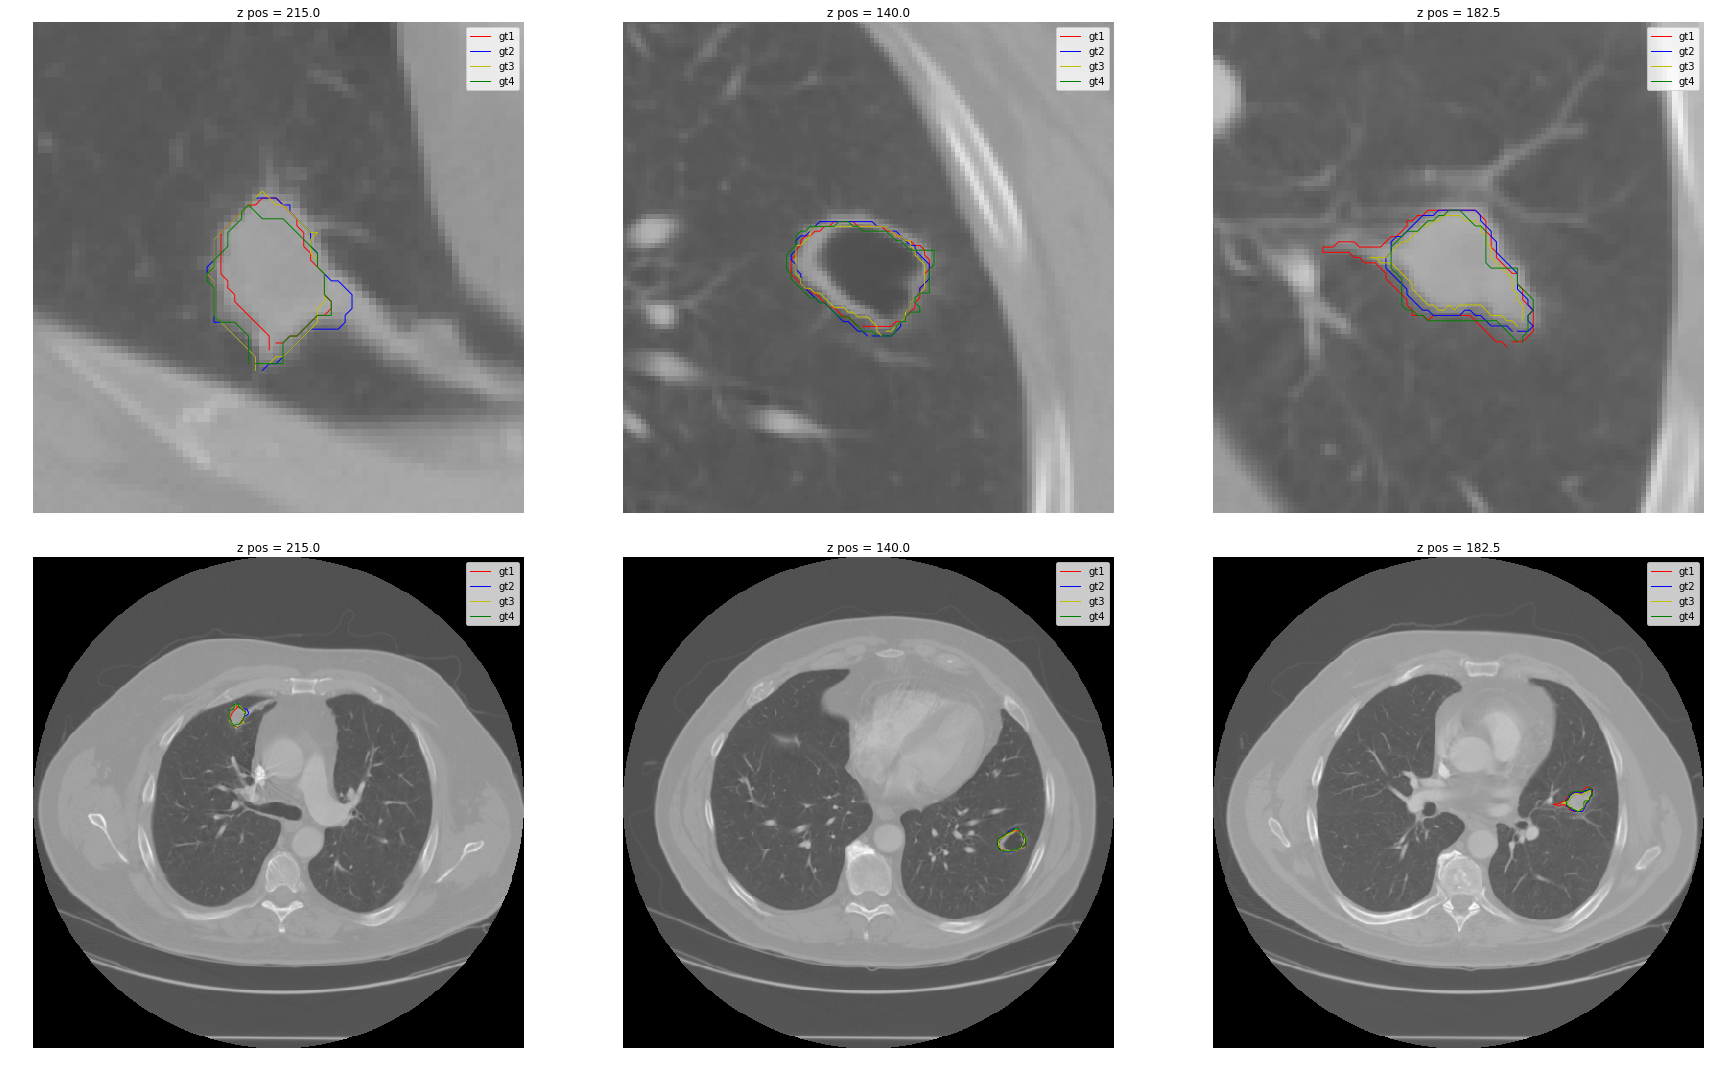

In [32]:
plot_label('272123398257168239653655006815')

### Very inconsistence example

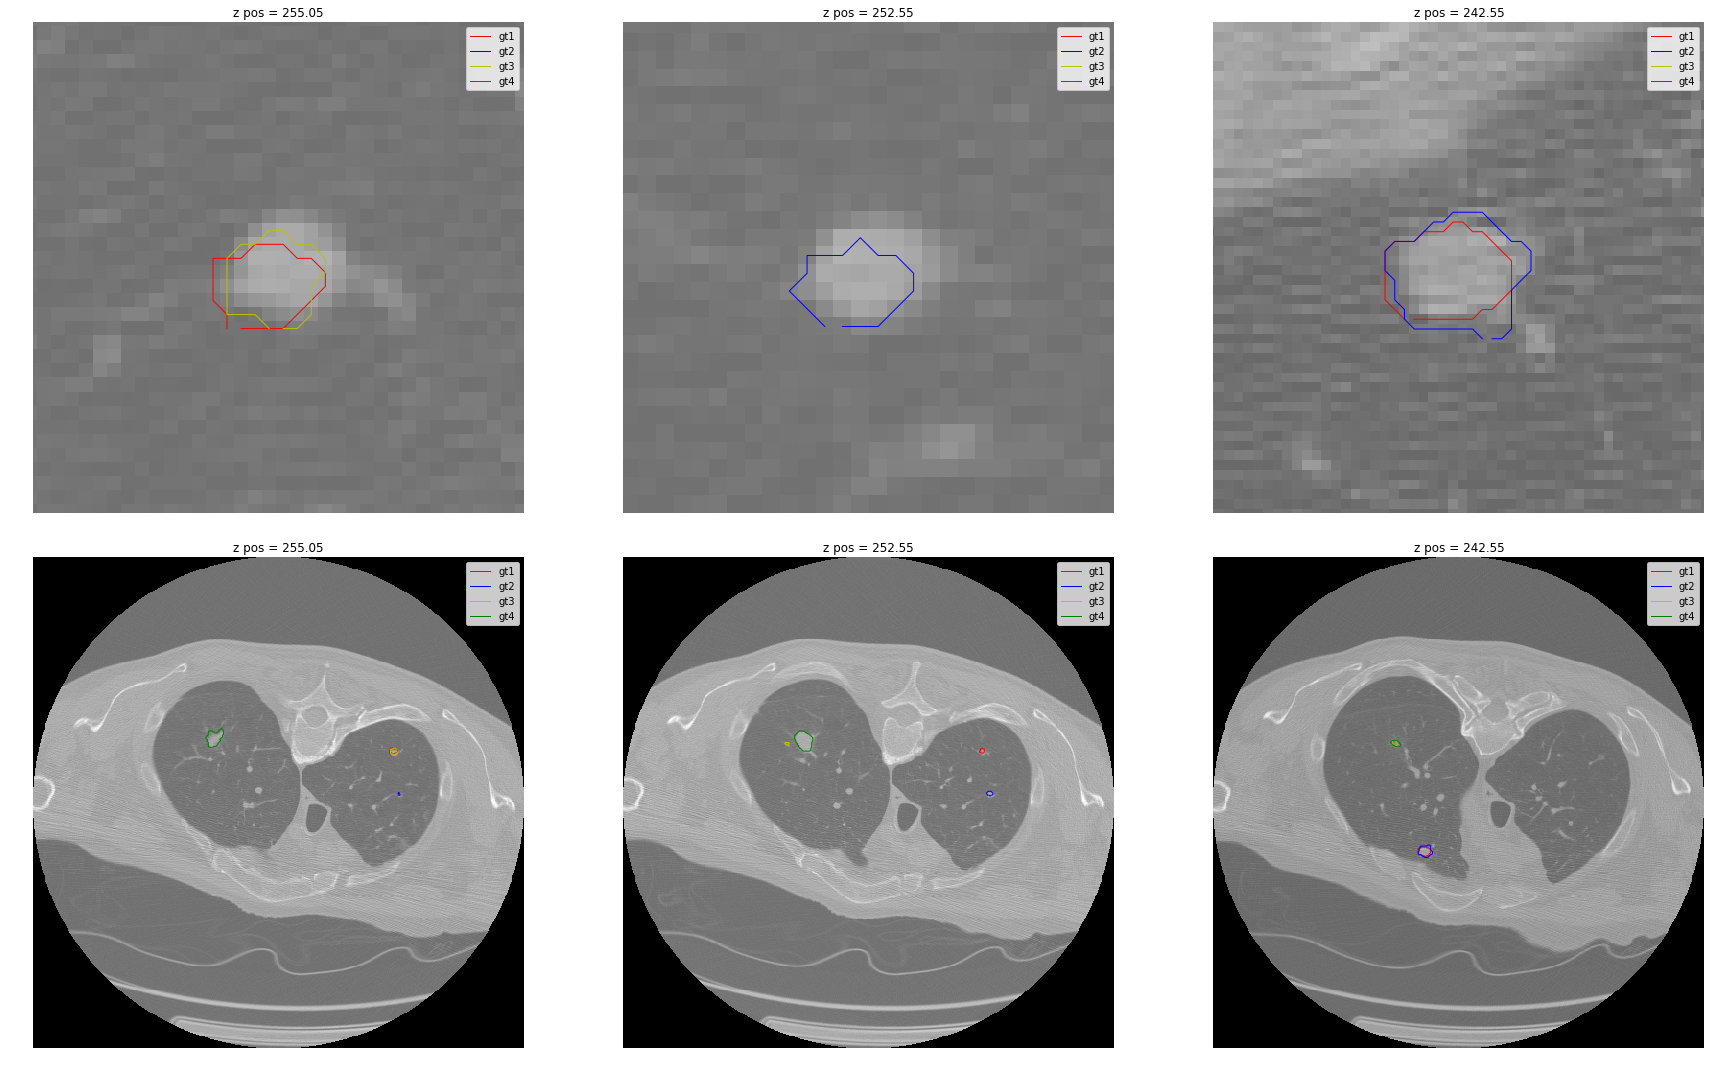

In [33]:
plot_label('964952370561266624992539111877')

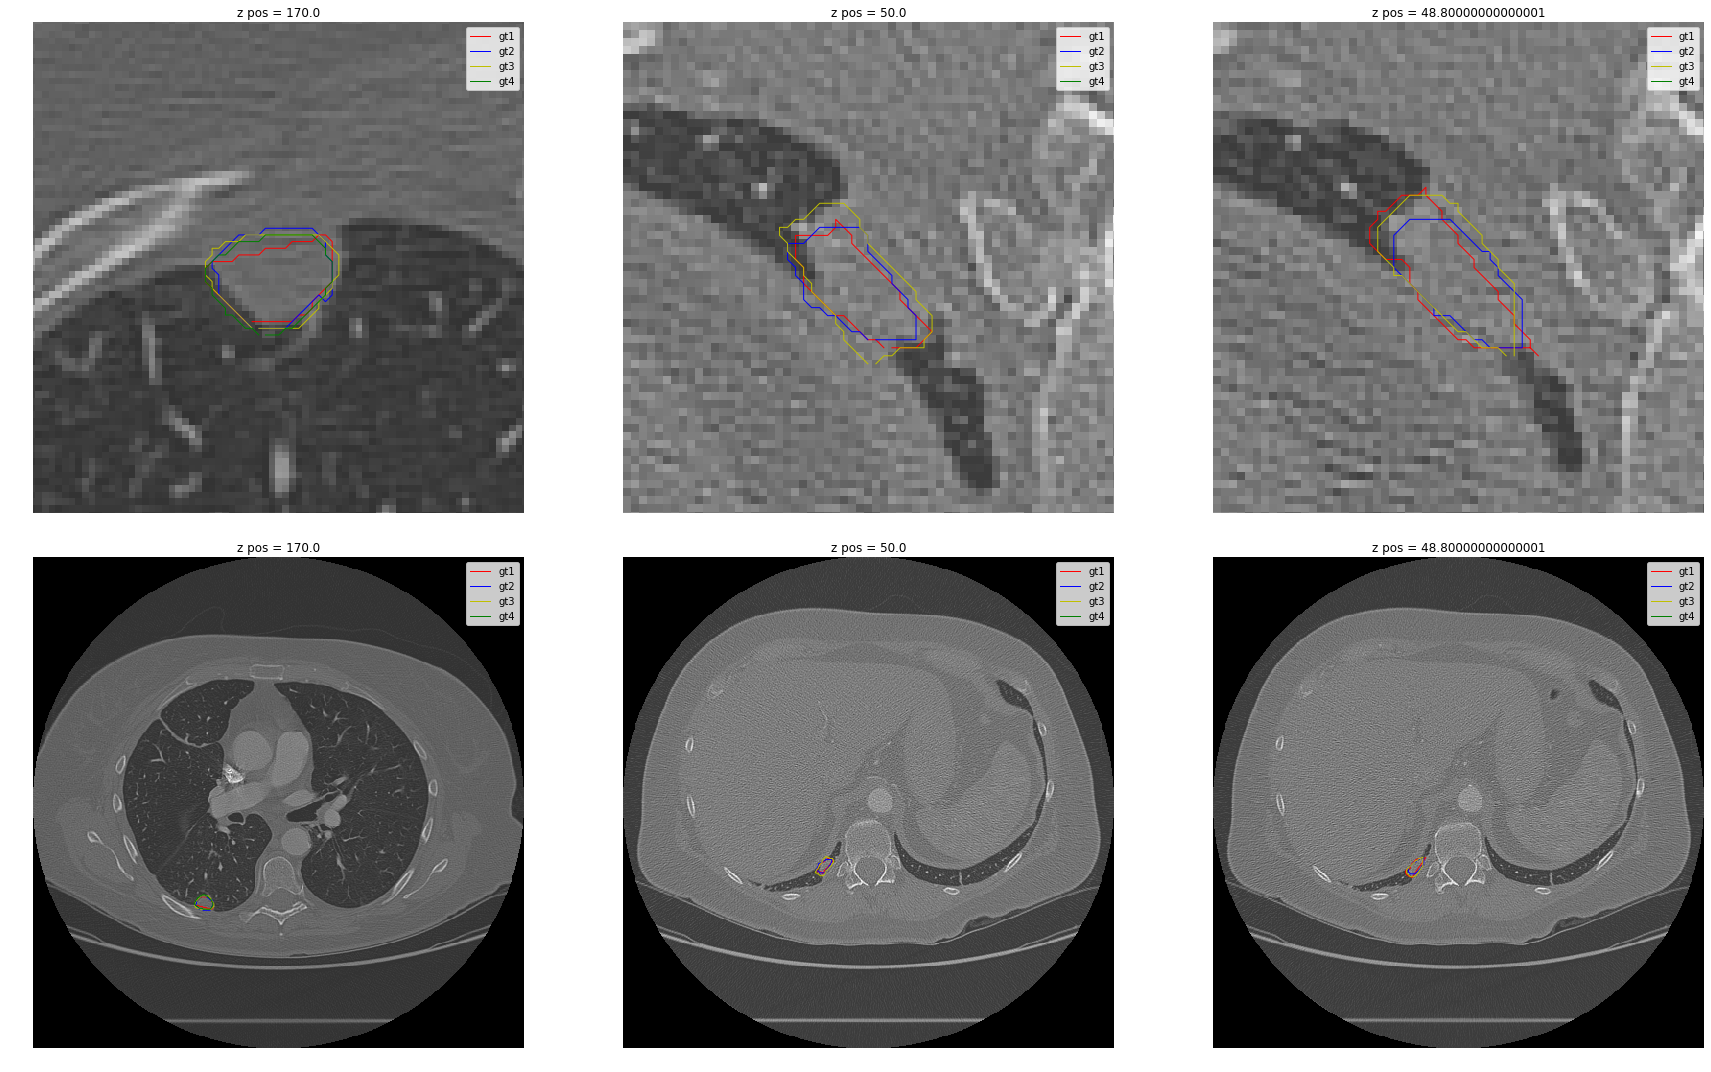

In [34]:
plot_label('133378195429627807109985347209')

In [ ]:
plot_label('272')

# Part 2

## Now let us decide to use labels of which radiologist
Use our preprocessed dicom gts and dicom segmented lungs

In [37]:
# Read New annotation
annotation_inscan = pd.read_csv(annotation_path[:-15] + 'annotation_in_scan.csv')
annotation_inscan.head()

seriesuid  coordX  coordY  coordZ  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...      29     136     140   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...     261     100     211   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...     240     169     160   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...      96     183     266   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...     122     163     252   

   diameter_mm  
0     5.651471  
1     4.224708  
2     5.786348  
3     8.143262  
4    18.545150

## Checking the gts of the sample scan 

### Load the sample scan gts first

In [38]:
seriesID = '964952370561266624992539111877'
#seriesID = '272123398257168239653655006815'    #<----replace seriesID here
full_seriesID = '1.3.6.1.4.1.14519.5.2.1.6279.6001.' + seriesID
gt_dicom_path = '/home/raphael/Projects/DL-Lung_Nodule_LUNA16/Solutions/LungAndNoduleMasks/3DNoduleMasks/'
dicom_gt_filenames = glob(gt_dicom_path +'1.3.6.1.4.1.14519.5.2.1.6279.6001.' + seriesID +'_GT*')

In [39]:
dicom_gt_filenames

['/home/raphael/Projects/DL-Lung_Nodule_LUNA16/Solutions/LungAndNoduleMasks/3DNoduleMasks/1.3.6.1.4.1.14519.5.2.1.6279.6001.964952370561266624992539111877_GT3.dcm',
 '/home/raphael/Projects/DL-Lung_Nodule_LUNA16/Solutions/LungAndNoduleMasks/3DNoduleMasks/1.3.6.1.4.1.14519.5.2.1.6279.6001.964952370561266624992539111877_GT2.dcm',
 '/home/raphael/Projects/DL-Lung_Nodule_LUNA16/Solutions/LungAndNoduleMasks/3DNoduleMasks/1.3.6.1.4.1.14519.5.2.1.6279.6001.964952370561266624992539111877_GT4.dcm',
 '/home/raphael/Projects/DL-Lung_Nodule_LUNA16/Solutions/LungAndNoduleMasks/3DNoduleMasks/1.3.6.1.4.1.14519.5.2.1.6279.6001.964952370561266624992539111877_GT1.dcm']

In [40]:
gt_scan_obj = []
for id in range(4):
    gt_scan_obj.append(pydicom.dcmread(dicom_gt_filenames[id]))

In [41]:
gt_scan_obj[0].Rows, gt_scan_obj[0].Columns, gt_scan_obj[0].NumberOfFrames

(350, 350, "314")

In [42]:
gt_scan1 = gt_scan_obj[0].pixel_array;
gt_scan2 = gt_scan_obj[1].pixel_array;
gt_scan3 = gt_scan_obj[2].pixel_array;
gt_scan4 = gt_scan_obj[3].pixel_array;
print('(z,x,y) : ', np.shape(gt_scan1))  # Note that all the gt_scans should have the same dimension

(z,x,y) :  (314, 350, 350)


**Load LUNA annotation of this scan**

In [43]:
sub_nodules = annotation_inscan[annotation_inscan['seriesuid'] == full_seriesID]
sub_nodules

seriesuid  coordX  coordY  \
1172  1.3.6.1.4.1.14519.5.2.1.6279.6001.964952370561...     151     210   
1173  1.3.6.1.4.1.14519.5.2.1.6279.6001.964952370561...     130     132   
1174  1.3.6.1.4.1.14519.5.2.1.6279.6001.964952370561...     257     139   
1175  1.3.6.1.4.1.14519.5.2.1.6279.6001.964952370561...     261     169   

      coordZ  diameter_mm  
1172     243     8.620605  
1173     249    14.914744  
1174     255     5.973406  
1175     253     4.723904

In [44]:
# LUNA coordinates of a specific scan
sub_X = np.abs(np.array(sub_nodules['coordX']))
sub_Y = np.abs(np.array(sub_nodules['coordY']))
sub_Z = np.array(sub_nodules['coordZ'])
sub_r = np.array(sub_nodules['diameter_mm'])

### Test if the centers of LUNA nodules are in annotation voxls of those radiologists

In [45]:
[gt_scan1[sub_Z[i], sub_X[i], sub_Y[i]] == 1 for i in range(len(sub_X))]

[False, False, True, False]

In [46]:
[gt_scan2[sub_Z[i], sub_X[i], sub_Y[i]] == 1 for i in range(len(sub_X))]

[True, True, True, True]

In [47]:
[gt_scan3[sub_Z[i], sub_X[i], sub_Y[i]] == 1 for i in range(len(sub_X))]

[False, True, True, False]

In [48]:
[gt_scan4[sub_Z[i], sub_X[i], sub_Y[i]] == 1 for i in range(len(sub_X))]

[True, True, True, False]

**Comment**: This is absolutely not correct, because LUNA only accept nodules that have at least three radiologists' labels. Let's check what is wrong.

### Check the gt4, which has 6 labeled nodules but only one of them is in LUNA annotation

In [57]:
gt_sub = gt_scan1
from skimage import measure
all_labels = measure.label(gt_sub)
properties = measure.regionprops(all_labels)
properties.sort(key = lambda x: x.area, reverse = True)

In [58]:
# find all the araes and centers(z, x, y) of ground truth nodele labels
gt_scan_area = []
gt_scan_Z = []
gt_scan_X = []
gt_scan_Y = []
for idx in range(np.shape(properties)[0]):
    gt_scan_area.append(properties[idx].area)
    gt_scan_Z.append(properties[idx].centroid[0])
    gt_scan_X.append(properties[idx].centroid[1])
    gt_scan_Y.append(properties[idx].centroid[2])

In [59]:
gt_scan_Y, gt_scan_X, gt_scan_area

([131.93935483870968,
  130.58064516129033,
  138.3763440860215,
  117.12658227848101,
  209.40845070422534,
  132.76923076923077],
 [128.9741935483871,
  80.08064516129032,
  256.3010752688172,
  102.36708860759494,
  150.14084507042253,
  116.23076923076923],
 [775, 124, 93, 79, 71, 26])

## Test why the center of LUNA labels are not in Ground Truth labels

<Figure size 1800x720 with 0 Axes>

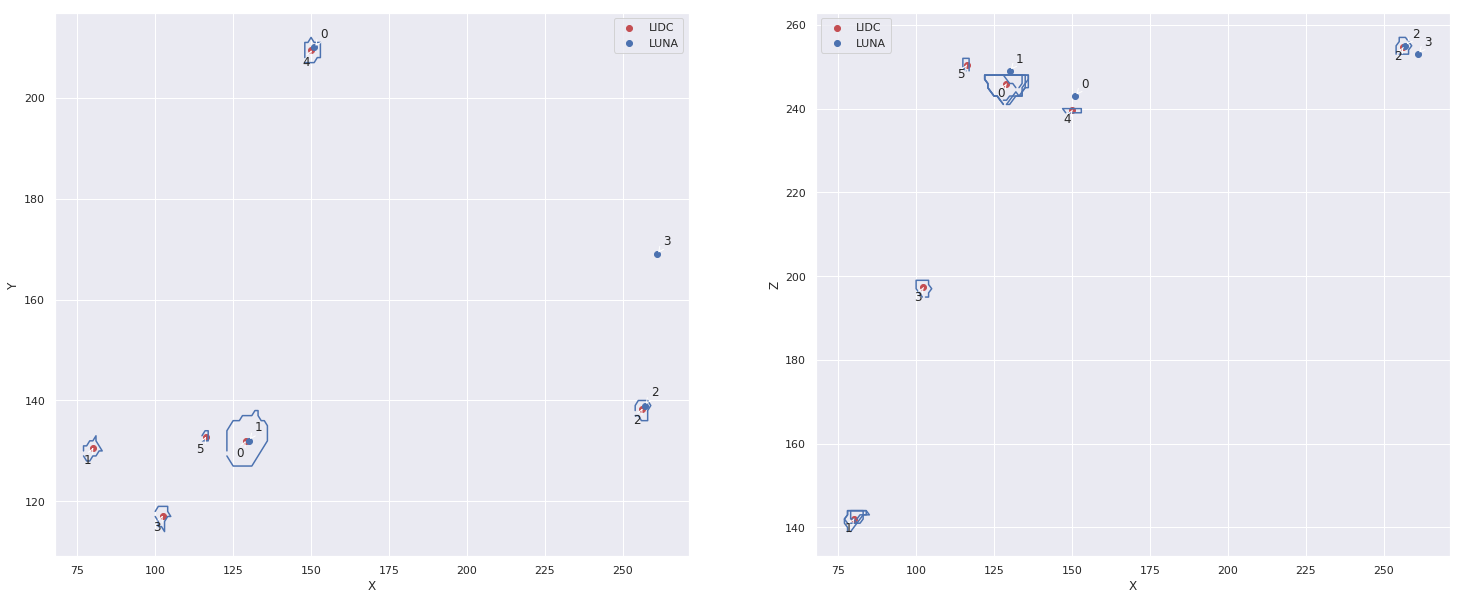

In [60]:
plt.rcParams['figure.figsize']= [25, 10]
sns.set();
plt.figure();
fig, (a, b) = plt.subplots(1,2);
for idx in range(len(gt_scan_X)):
    l1 = a.scatter(gt_scan_X[idx], gt_scan_Y[idx], color = 'r');
    contour = plot_boundary(gt_sub[int(gt_scan_Z[idx]), :, :],threshold = 0.5, maxvalue = 1)
    x = contour[:, 0]
    y = contour[:, 1]
    a.plot(y,x, color = 'b')
    a.annotate(idx, [gt_scan_X[idx], gt_scan_Y[idx]],xytext = [gt_scan_X[idx]-3, gt_scan_Y[idx]-3] , arrowprops=dict(arrowstyle="->", connectionstyle="arc3"));
for idx in range(len(sub_X)):
    l2 = a.scatter(sub_X[idx], sub_Y[idx], color = 'b');
    a.annotate(idx, [sub_X[idx], sub_Y[idx]],xytext = [sub_X[idx]+2, sub_Y[idx]+2] , arrowprops=dict(arrowstyle="->", connectionstyle="arc3"));
a.set_ylabel('Y')
a.set_xlabel('X')
a.legend((l1, l2), ('LIDC', 'LUNA'));


for idx in range(len(gt_scan_X)):
    l1 = b.scatter(gt_scan_X[idx], gt_scan_Z[idx], color = 'r');
    contour = plot_boundary(gt_sub[:, :, int(gt_scan_Y[idx])], threshold = 0.5, maxvalue = 1)
    if len(np.shape(contour)) == 1:
        for i in range(np.shape(contour)[0]):
            contour_i = np.squeeze(contour[i])
            x = contour_i[:, 0]
            y = contour_i[:, 1]
            b.plot(x,y, color = 'b')
    elif len(np.shape(contour)) > 1:
        x = contour[:, 0]
        z = contour[:, 1]
        b.plot(x,z, color = 'b')
    else:
        np.error('no bounday in' + str(idx))
    b.annotate(idx, [gt_scan_X[idx], gt_scan_Z[idx]],xytext = [gt_scan_X[idx]-3, gt_scan_Z[idx]-3] , arrowprops=dict(arrowstyle="->", connectionstyle="arc3"));
for idx in range(len(sub_X)):
    l2 = b.scatter(sub_X[idx], sub_Z[idx], color = 'b');
    b.annotate(idx, [sub_X[idx], sub_Z[idx]],xytext = [sub_X[idx]+2, sub_Z[idx]+2] , arrowprops=dict(arrowstyle="->", connectionstyle="arc3"));
b.legend((l1, l2), ('LIDC', 'LUNA'),loc="upper left");
b.set_ylabel('Z')
b.set_xlabel('X')

plt.show();

**Comment**: Now we can see LIDC0 and LUNA1 are the same nodule, but the probably because the radiologist only tend to label one nodule per slice, the radilogist start to label LIDC5 in the center of the LUNA1 nodule. And the same thing happened on LIDC4 and LUNA0.

In [61]:
# Let's see what is wrong with LIDC gt4, nodule 4 (the 4th properties)
properties[4].coords
X_test = properties[4].coords[:, 1]
Y_test = properties[4].coords[:, 2]
Z_test = properties[4].coords[:, 0]

In [62]:
# Bulid a XYZ cube that dimension is (x,y,z), same with the voxel plot dimension
XYZcube = np.zeros([properties[4].bbox[4]-properties[4].bbox[1], properties[4].bbox[5]-properties[4].bbox[2], properties[4].bbox[3]-properties[4].bbox[0]])
XYZcube[properties[4].coords[:,1]- properties[4].bbox[1], properties[4].coords[:,2]-properties[4].bbox[2], properties[4].coords[:,0]- properties[4].bbox[0]] = 1
XYZcube = np.uint8(XYZcube)

In [63]:
print('Bounding box (z1, y1 ,x1, z2, y2, x2) :', properties[4].bbox, '\nNodule center (z, x, y): ', properties[4].centroid)
print('LUNA nodule0 (z, x, y): ', sub_Z[0], sub_X[0], sub_Y[0])

Bounding box (z1, y1 ,x1, z2, y2, x2) : (239, 147, 206, 242, 154, 214) 
Nodule center (z, x, y):  (239.6338028169014, 150.14084507042253, 209.40845070422534)
LUNA nodule0 (z, x, y):  243 151 210


In [64]:
LUNAcube = np.zeros([properties[4].bbox[4]-properties[4].bbox[1], properties[4].bbox[5]-properties[4].bbox[2], properties[4].bbox[3]-properties[4].bbox[0]+2])
LUNAcube[sub_X[0]- properties[4].bbox[1], sub_Y[0]-properties[4].bbox[2], sub_Z[0]- properties[4].bbox[0]] = 1
LUNAcube = np.uint8(LUNAcube)

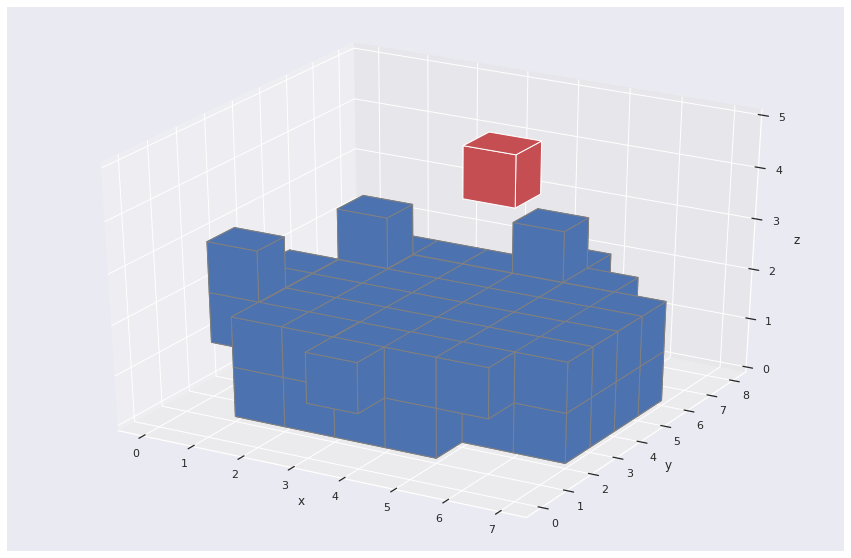

In [65]:
plt.rcParams['figure.figsize']= [15, 10]
from mpl_toolkits.mplot3d import Axes3D
def make_ax(grid=False):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.grid(grid)
    return ax

ax = make_ax(True)
ax.voxels(XYZcube, edgecolors='gray')
ax.voxels(LUNAcube, facecolor = 'r')
plt.show()

### Let us change the strategy

In [66]:
gt_scan_X, sub_X, sub_r

([128.9741935483871,
  80.08064516129032,
  256.3010752688172,
  102.36708860759494,
  150.14084507042253,
  116.23076923076923],
 array([151, 130, 257, 261]),
 array([ 8.62060467, 14.91474445,  5.97340567,  4.72390406]))

In [67]:
detectlist = []
for LUNA_idx in range(len(sub_X)):
    isnodule = 0
    for LIDC_idx in range(len(gt_scan_X)):
        if np.sqrt((gt_scan_X[LIDC_idx] - sub_X[LUNA_idx]) ** 2 + (gt_scan_Y[LIDC_idx] - sub_Y[LUNA_idx]) ** 2 + (gt_scan_Z[LIDC_idx] - sub_Z[LUNA_idx]) ** 2) < sub_r[LUNA_idx]:
            isnodule = 1
    if isnodule == 1:
        detectlist.append(1)
    else:
        detectlist.append(0)
detectlist

[1, 1, 1, 0]

**Comment**: This strategy works!!!

## Now let's make a pipeline to evaluate which radiologist's labels have the higest sensitivity

**Create subset**

In [68]:
start_point = 0
end_point = 50
sub_set = []
for i in range(601 // 50):    
    sub_set1 = np.unique(annotation_inscan['seriesuid'])[start_point : end_point]
    start_point += 50
    end_point += 50
    sub_set.append(sub_set1)

start_point = 601 // 50 * 50
end_point = 601
sub_set1 = np.unique(annotation_inscan['seriesuid'])[start_point : end_point]
sub_set.append(sub_set1)


## **Read and check annotations of radiologists**

### Check all of our gt files

In [69]:
for idxnum in range(len(sub_set)):
    for full_seriesID in sub_set[idxnum]:
        seriesID = full_seriesID.replace('1.3.6.1.4.1.14519.5.2.1.6279.6001.','')
        dicom_gt_filenames = glob(gt_dicom_path +'1.3.6.1.4.1.14519.5.2.1.6279.6001.' + seriesID +'_GT*')
        if len(dicom_gt_filenames) != 4:
            print(seriesID, len(dicom_gt_filenames))
    print('subset', idxnum, 'DONE!')

subset 0 DONE!
subset 1 DONE!
subset 2 DONE!
subset 3 DONE!
subset 4 DONE!
227885601428639043345478571594 0
subset 5 DONE!
subset 6 DONE!
subset 7 DONE!
subset 8 DONE!
subset 9 DONE!
subset 10 DONE!
subset 11 DONE!
subset 12 DONE!


In [153]:
gt_dicom_path = '/Volumes/Raphael_Invasion/Results/Nodule_Masks/'
acc_gt1 = []
acc_gt2 = []
acc_gt3 = []
acc_gt4 = []
acc_gt = [acc_gt1, acc_gt2, acc_gt3, acc_gt4]
file_seriesID = []
end_point = 10
badgtseries = ['227885601428639043345478571594'] # study ID: 181785797305004428693015149455

#for idxnum in range(len(sub_set)):
for idxnum in [5, 6, 7, 8, 9, 10, 11, 12]:
    for full_seriesID in sub_set[idxnum]:
        seriesID = full_seriesID.replace('1.3.6.1.4.1.14519.5.2.1.6279.6001.','')
        if seriesID in badgtseries:
            print(seriesID, 'Skipped')
        else:
            dicom_gt_filenames = glob(gt_dicom_path +'1.3.6.1.4.1.14519.5.2.1.6279.6001.' + seriesID +'_GT*')
            gt_scan_obj = []
            for id in range(4):
                gt_scan_obj.append(pydicom.dcmread(dicom_gt_filenames[id]))


            sub_nodules = annotation_inscan[annotation_inscan['seriesuid'] == full_seriesID]
            # LUNA coordinates of a specific scan
            sub_X = np.abs(np.array(sub_nodules['coordX']))
            sub_Y = np.abs(np.array(sub_nodules['coordY']))
            sub_Z = np.array(sub_nodules['coordZ'])
            sub_r = np.array(sub_nodules['diameter_mm'])

            for rad_id in range(4):    
                gt_sub = gt_scan_obj[rad_id].pixel_array;
                all_labels = measure.label(gt_sub)
                properties = measure.regionprops(all_labels)
                properties.sort(key = lambda x: x.area, reverse = True)
                gt_scan_area = []
                gt_scan_Z = []
                gt_scan_X = []
                gt_scan_Y = []
                for idx in range(np.shape(properties)[0]):
                    gt_scan_area.append(properties[idx].area)
                    gt_scan_Z.append(properties[idx].centroid[0])
                    gt_scan_X.append(properties[idx].centroid[1])
                    gt_scan_Y.append(properties[idx].centroid[2])
                detectlist = []
                for LUNA_idx in range(len(sub_X)):
                    isnodule = 0
                    for LIDC_idx in range(len(gt_scan_X)):
                        if np.sqrt((gt_scan_X[LIDC_idx] - sub_X[LUNA_idx]) ** 2 + (gt_scan_Y[LIDC_idx] - sub_Y[LUNA_idx]) ** 2 + (gt_scan_Z[LIDC_idx] - sub_Z[LUNA_idx]) ** 2) < sub_r[LUNA_idx]:
                            isnodule = 1
                    if isnodule == 1:
                        detectlist.append(1)
                    else:
                        detectlist.append(0)
                acc_gt[rad_id].append(detectlist)
            file_seriesID.append(seriesID)
        
    print('subset', idxnum, 'DONE!')
    
    

227885601428639043345478571594 Skipped
subset 5 DONE!
subset 6 DONE!
subset 7 DONE!
subset 8 DONE!
subset 9 DONE!
subset 10 DONE!
subset 11 DONE!
subset 12 DONE!


In [182]:
sub_nodules = annotation_inscan[annotation_inscan['seriesuid'] == '1.3.6.1.4.1.14519.5.2.1.6279.6001.227885601428639043345478571594']
sub_nodules 

seriesuid  coordX  coordY  \
535  1.3.6.1.4.1.14519.5.2.1.6279.6001.227885601428...     105     271   

     coordZ  diameter_mm  
535     191     6.313682


with open("acc_gt1.txt", "w") as file:
    file.write(str(acc_gt))

with open("file_seriesID1.txt", "w") as file:
    file.write(str(file_seriesID))


with open("acc_gt2.txt", "w") as file:
    file.write(str(acc_gt))

with open("file_seriesID2.txt", "w") as file:
    file.write(str(file_seriesID))

**Load saved files**

In [169]:
with open("acc_gt1.txt", "r") as file:
    acc_gt1 = eval(file.readline())
    
with open("file_seriesID1.txt", "r") as file:
    file_seriesID1 = eval(file.readline())

with open("acc_gt2.txt", "r") as file:
    acc_gt2 = eval(file.readline())
    
with open("file_seriesID2.txt", "r") as file:
    file_seriesID2 = eval(file.readline())

In [192]:
np.shape(acc_gt1[0])[0] + np.shape(acc_gt2[0])[0] - 5 + 1, len(np.unique(annotation_inscan['seriesuid']))

(601, 601)

In [183]:
sum([len(acc_gt1[1][i]) for i in range(len(acc_gt1[1]))]) + sum([len(acc_gt2[1][i]) for i in range(5,len(acc_gt2[1]))]) + 1, np.shape(annotation_inscan['seriesuid'])

(1186, (1186,))

## Now calculate the sensitivity of labels of those radiologists

In [194]:
id = 0
id0_hit = sum([sum(acc_gt1[id][i]) for i in range(len(acc_gt1[id]))]) + sum([sum(acc_gt2[id][i]) for i in range(5,len(acc_gt2[id]))])

In [195]:
id = 1
id1_hit = sum([sum(acc_gt1[id][i]) for i in range(len(acc_gt1[id]))]) + sum([sum(acc_gt2[id][i]) for i in range(5,len(acc_gt2[id]))])

In [196]:
id = 2
id2_hit = sum([sum(acc_gt1[id][i]) for i in range(len(acc_gt1[id]))]) + sum([sum(acc_gt2[id][i]) for i in range(5,len(acc_gt2[id]))])

In [197]:
id = 3
id3_hit = sum([sum(acc_gt1[id][i]) for i in range(len(acc_gt1[id]))]) + sum([sum(acc_gt2[id][i]) for i in range(5,len(acc_gt2[id]))])

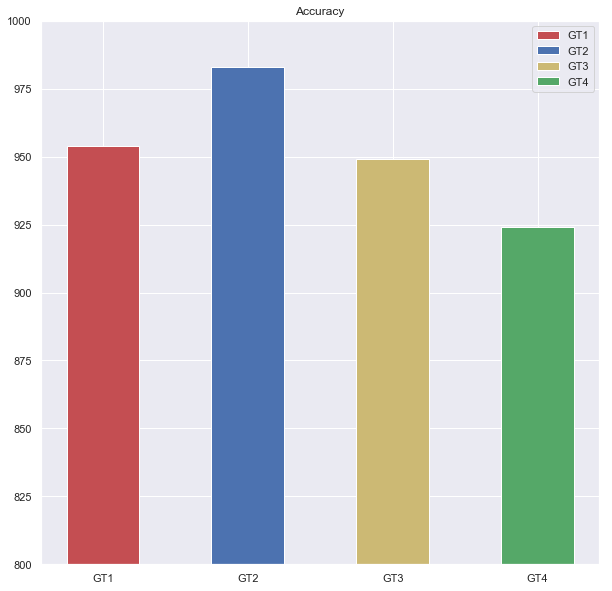

In [332]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
x = np.arange(4)
p1 = plt.bar(x, [id0_hit, 0, 0, 0], width = 0.5,color='r')
p2 = plt.bar(x, [0, id1_hit, 0, 0], width = 0.5,color='b')
p3 = plt.bar(x, [0, 0, id2_hit, 0], width = 0.5,color='y')
p4 = plt.bar(x, [0, 0, 0, id3_hit], width = 0.5,color='g')
plt.title('Accuracy')
plt.xticks(x, ['GT1','GT2','GT3', 'GT4'])
plt.legend(['GT1','GT2','GT3', 'GT4' ])
plt.ylim([800, 1000])
plt.show()


### Check resized result

In [115]:
seriesID = '133378195429627807109985347209'
# note that sample_id is SeriesInstanceUID
sample_id = '1.3.6.1.4.1.14519.5.2.1.6279.6001.' + seriesID

raw_dicom_path = '/home/raphael/Projects/DL-Lung_Nodule_LUNA16/Solutions/LungAndNoduleMasks/3DLungMasks/Preprocessed/'
seg_dicom_path = '/home/raphael/Projects/DL-Lung_Nodule_LUNA16/Solutions/LungAndNoduleMasks/3DLungMasks/Segmented/'
dicom_raw_filenames = glob(raw_dicom_path +'1.3.6.1.4.1.14519.5.2.1.6279.6001.' + seriesID +'_preprocessed.dcm')
dicom_seg_filenames = glob(seg_dicom_path +'1.3.6.1.4.1.14519.5.2.1.6279.6001.' + seriesID +'_segmented.dcm')
raw_scan_obj = pydicom.dcmread(dicom_raw_filenames[0])
seg_scan_obj = pydicom.dcmread(dicom_seg_filenames[0])
raw_scan = raw_scan_obj.pixel_array;
seg_scan = seg_scan_obj.pixel_array;
dicom_gt_filenames = glob(gt_dicom_path +'1.3.6.1.4.1.14519.5.2.1.6279.6001.' + seriesID +'_GT*')
gt_scan_obj = []
for id in range(4):
    gt_scan_obj.append(pydicom.dcmread(dicom_gt_filenames[id]))
gt_scan1 = gt_scan_obj[0].pixel_array;
gt_scan2 = gt_scan_obj[1].pixel_array;
gt_scan3 = gt_scan_obj[2].pixel_array;
gt_scan4 = gt_scan_obj[3].pixel_array;


nodule_z = np.array(annotation_inscan[annotation_inscan['seriesuid'] == sample_id]['coordZ'])
nodule_x = np.array(annotation_inscan[annotation_inscan['seriesuid'] == sample_id]['coordX'])
nodule_y = np.array(annotation_inscan[annotation_inscan['seriesuid'] == sample_id]['coordY'])
nodule_r = np.array(annotation_inscan[annotation_inscan['seriesuid'] == sample_id]['diameter_mm'])

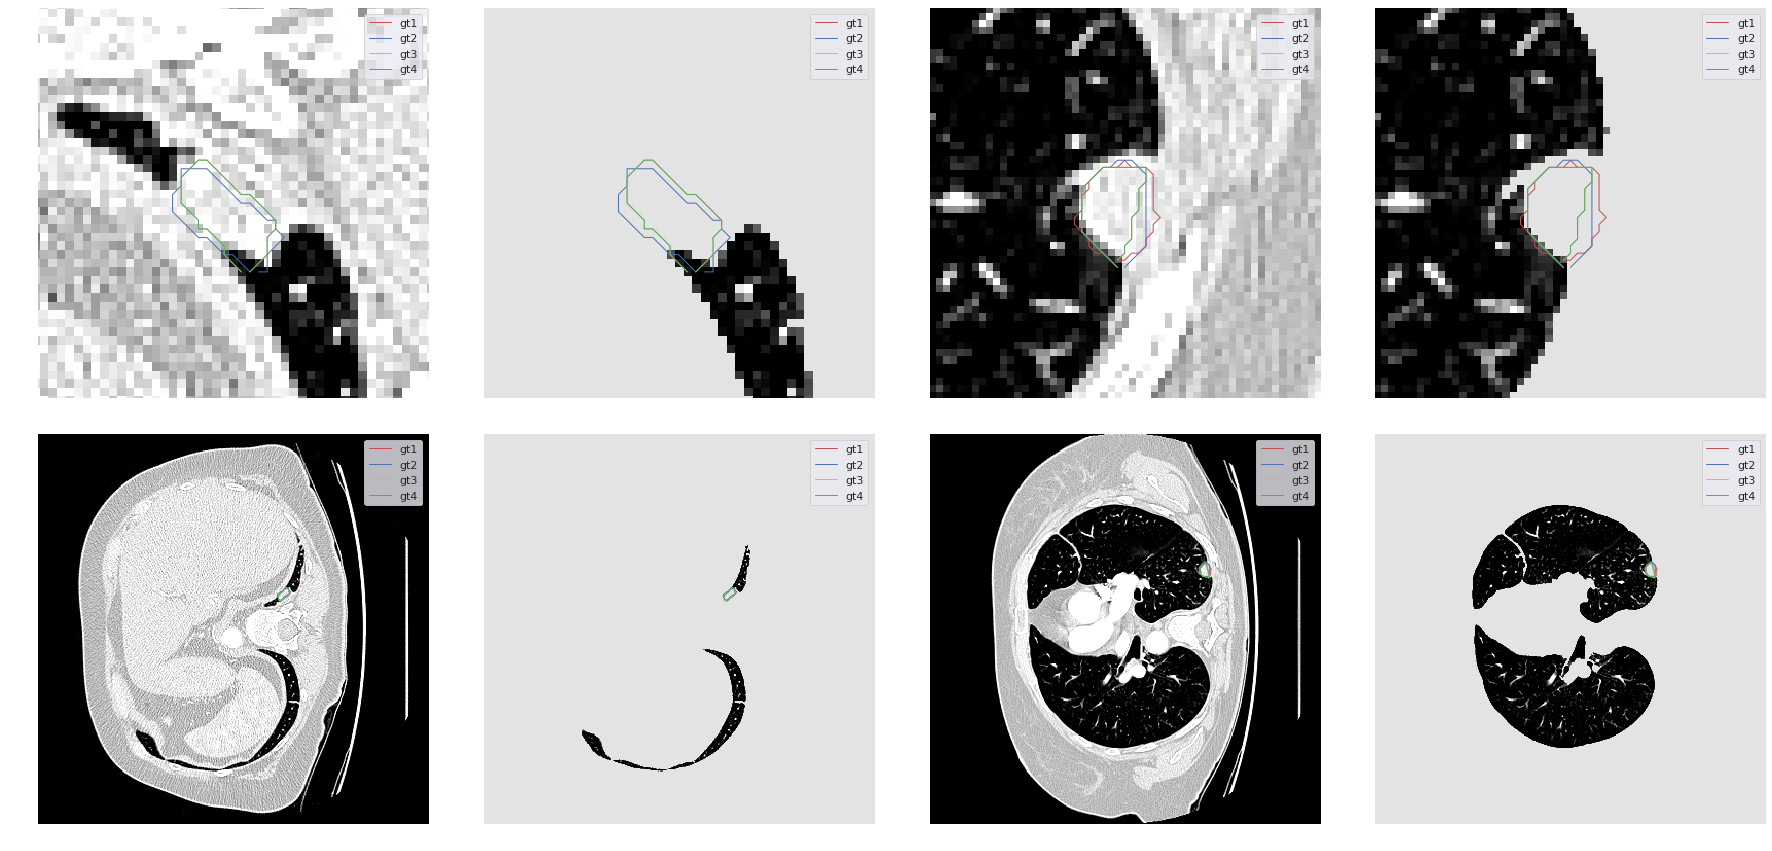

In [116]:
plt.rcParams['figure.figsize']= [25, 12]
fig, ax = plt.subplots(2,4)
fig.set_tight_layout(True)

idx = 0


contours = plot_boundary(gt_scan1[int(nodule_z[idx]), :, :], threshold = 0.5, maxvalue = 1)
x1 = contours[:, 0]
y1 = contours[:, 1]
contours = plot_boundary(gt_scan2[int(nodule_z[idx]), :, :], threshold = 0.5, maxvalue = 1)
x2 = contours[:, 0]
y2 = contours[:, 1]
contours = plot_boundary(gt_scan3[int(nodule_z[idx]), :, :], threshold = 0.5, maxvalue = 1)
x3 = contours[:, 0]
y3 = contours[:, 1]
contours = plot_boundary(gt_scan3[int(nodule_z[idx]), :, :], threshold = 0.5, maxvalue = 1)
x4 = contours[:, 0]
y4 = contours[:, 1]



ax[0,0].imshow(raw_scan[int(nodule_z[idx]), :, :], cmap = 'gray');
ax[0,0].plot(x1, y1, color = 'r', linewidth = 1);
ax[0,0].plot(x2, y2, color = 'b', linewidth = 1);
ax[0,0].plot(x3, y3, color = 'y', linewidth = 1);
ax[0,0].plot(x4, y4, color = 'g', linewidth = 1);
ax[0,0].legend(['gt1', 'gt2', 'gt3', 'gt4'])
ax[0,0].set_ylim([nodule_x[idx] - 2 * nodule_r[idx], nodule_x[idx] + 2 * nodule_r[idx]])
ax[0,0].set_xlim([nodule_y[idx] - 2 * nodule_r[idx], nodule_y[idx] + 2 * nodule_r[idx]])
ax[0,0].axis('off')


ax[0,1].imshow(seg_scan[int(nodule_z[idx]), :, :], cmap = 'gray');
ax[0,1].plot(x1, y1, color = 'r', linewidth = 1);
ax[0,1].plot(x2, y2, color = 'b', linewidth = 1);
ax[0,1].plot(x3, y3, color = 'y', linewidth = 1);
ax[0,1].plot(x4, y4, color = 'g', linewidth = 1);
ax[0,1].legend(['gt1', 'gt2', 'gt3', 'gt4'])
ax[0,1].set_ylim([nodule_x[idx] - 2 * nodule_r[idx], nodule_x[idx] + 2 * nodule_r[idx]])
ax[0,1].set_xlim([nodule_y[idx] - 2 * nodule_r[idx], nodule_y[idx] + 2 * nodule_r[idx]])
ax[0,1].axis('off')





ax[1,0].imshow(raw_scan[int(nodule_z[idx]), :, :], cmap = 'gray');
ax[1,0].plot(x1, y1, color = 'r', linewidth = 1);
ax[1,0].plot(x2, y2, color = 'b', linewidth = 1);
ax[1,0].plot(x3, y3, color = 'y', linewidth = 1);
ax[1,0].plot(x4, y4, color = 'g', linewidth = 1);
ax[1,0].legend(['gt1', 'gt2', 'gt3', 'gt4'])
ax[1,0].axis('off')

ax[1,1].imshow(seg_scan[int(nodule_z[idx]), :, :], cmap = 'gray');
ax[1,1].plot(x1, y1, color = 'r', linewidth = 1);
ax[1,1].plot(x2, y2, color = 'b', linewidth = 1);
ax[1,1].plot(x3, y3, color = 'y', linewidth = 1);
ax[1,1].plot(x4, y4, color = 'g', linewidth = 1);
ax[1,1].legend(['gt1', 'gt2', 'gt3', 'gt4'])
ax[1,1].axis('off')


idx = 1


contours = plot_boundary(gt_scan1[int(nodule_z[idx]), :, :], threshold = 0.5, maxvalue = 1)
x1 = contours[:, 0]
y1 = contours[:, 1]
contours = plot_boundary(gt_scan2[int(nodule_z[idx]), :, :], threshold = 0.5, maxvalue = 1)
x2 = contours[:, 0]
y2 = contours[:, 1]
contours = plot_boundary(gt_scan3[int(nodule_z[idx]), :, :], threshold = 0.5, maxvalue = 1)
x3 = contours[:, 0]
y3 = contours[:, 1]
contours = plot_boundary(gt_scan3[int(nodule_z[idx]), :, :], threshold = 0.5, maxvalue = 1)
x4 = contours[:, 0]
y4 = contours[:, 1]



ax[0,2].imshow(raw_scan[int(nodule_z[idx]), :, :], cmap = 'gray');
ax[0,2].plot(x1, y1, color = 'r', linewidth = 1);
ax[0,2].plot(x2, y2, color = 'b', linewidth = 1);
ax[0,2].plot(x3, y3, color = 'y', linewidth = 1);
ax[0,2].plot(x4, y4, color = 'g', linewidth = 1);
ax[0,2].legend(['gt1', 'gt2', 'gt3', 'gt4'])
ax[0,2].set_ylim([nodule_x[idx] - 2 * nodule_r[idx], nodule_x[idx] + 2 * nodule_r[idx]])
ax[0,2].set_xlim([nodule_y[idx] - 2 * nodule_r[idx], nodule_y[idx] + 2 * nodule_r[idx]])
ax[0,2].axis('off')


ax[0,3].imshow(seg_scan[int(nodule_z[idx]), :, :], cmap = 'gray');
ax[0,3].plot(x1, y1, color = 'r', linewidth = 1);
ax[0,3].plot(x2, y2, color = 'b', linewidth = 1);
ax[0,3].plot(x3, y3, color = 'y', linewidth = 1);
ax[0,3].plot(x4, y4, color = 'g', linewidth = 1);
ax[0,3].legend(['gt1', 'gt2', 'gt3', 'gt4'])
ax[0,3].set_ylim([nodule_x[idx] - 2 * nodule_r[idx], nodule_x[idx] + 2 * nodule_r[idx]])
ax[0,3].set_xlim([nodule_y[idx] - 2 * nodule_r[idx], nodule_y[idx] + 2 * nodule_r[idx]])
ax[0,3].axis('off')





ax[1,2].imshow(raw_scan[int(nodule_z[idx]), :, :], cmap = 'gray');
ax[1,2].plot(x1, y1, color = 'r', linewidth = 1);
ax[1,2].plot(x2, y2, color = 'b', linewidth = 1);
ax[1,2].plot(x3, y3, color = 'y', linewidth = 1);
ax[1,2].plot(x4, y4, color = 'g', linewidth = 1);
ax[1,2].legend(['gt1', 'gt2', 'gt3', 'gt4'])
ax[1,2].axis('off')

ax[1,3].imshow(seg_scan[int(nodule_z[idx]), :, :], cmap = 'gray');
ax[1,3].plot(x1, y1, color = 'r', linewidth = 1);
ax[1,3].plot(x2, y2, color = 'b', linewidth = 1);
ax[1,3].plot(x3, y3, color = 'y', linewidth = 1);
ax[1,3].plot(x4, y4, color = 'g', linewidth = 1);
ax[1,3].legend(['gt1', 'gt2', 'gt3', 'gt4'])
ax[1,3].axis('off')
plt.show()


## Visualize the segmentation result and nodule masks

In [102]:
seriesID = '272123398257168239653655006815'
dicom_raw_filenames = glob(raw_dicom_path +'1.3.6.1.4.1.14519.5.2.1.6279.6001.' + seriesID +'_preprocessed.dcm')
dicom_seg_filenames = glob(seg_dicom_path +'1.3.6.1.4.1.14519.5.2.1.6279.6001.' + seriesID +'_segmented.dcm')

In [103]:
dicom_gt_filenames = glob(gt_dicom_path +'1.3.6.1.4.1.14519.5.2.1.6279.6001.' + seriesID +'_GT*')
gt_scan_obj = []
for id in range(4):
    gt_scan_obj.append(pydicom.dcmread(dicom_gt_filenames[id]))
gt_scan1 = gt_scan_obj[0].pixel_array;
gt_scan2 = gt_scan_obj[1].pixel_array;
gt_scan3 = gt_scan_obj[2].pixel_array;
gt_scan4 = gt_scan_obj[3].pixel_array;

In [104]:
raw_scan_obj = pydicom.dcmread(dicom_raw_filenames[0])
seg_scan_obj = pydicom.dcmread(dicom_seg_filenames[0])
raw_scan_obj.Rows, raw_scan_obj.Columns, raw_scan_obj.NumberOfFrames, seg_scan_obj.Rows, seg_scan_obj.Columns, seg_scan_obj.NumberOfFrames

(440, 440, "333", 440, 440, "333")

In [105]:
raw_scan = raw_scan_obj.pixel_array;
seg_scan = seg_scan_obj.pixel_array;

In [106]:
np.shape(seg_scan)

(333, 440, 440)

In [107]:
ipv.figure()
ipv.volshow(raw_scan, level = [0.27, 0.47], opacity = [0.036, 0.24])

ipv.pylab.ylabel('x')
ipv.pylab.xlabel('y')
ipv.style.box_off()
ipv.style.axes_off()

ipv.show()

In [108]:
ipv.figure()
ipv.volshow(seg_scan, level = [0.12, 0.25], opacity = [0, 0.3])

ipv.pylab.ylabel('x')
ipv.pylab.xlabel('y')
ipv.style.box_off()
ipv.style.axes_off()

ipv.show()

In [111]:
ipv.figure()
#ipv.volshow(gt_scan1, level = [1], opacity = 1, data_min = 0, data_max = 1)
#ipv.volshow(gt_scan2, level = [1], opacity = 1, data_min = 0, data_max = 1)
#ipv.volshow(gt_scan3, level = [1], opacity = 1, data_min = 0, data_max = 1)
ipv.volshow(gt_scan3, level = [1], opacity = 1, data_min = 0, data_max = 1)
ipv.volshow(seg_scan, level = [0.12, 0.25], opacity = [0, 0.1])

ipv.pylab.ylabel('x')
ipv.pylab.xlabel('y')
ipv.style.box_off()
ipv.style.axes_off()

ipv.show()

In [110]:
result_scan_path = '/home/raphael/Projects/DL-Lung_Nodule_LUNA16/results/'+seriesID+'.dcm'
result_scan_id4 = pydicom.dcmread(result_scan_path).pixel_array
ipv.figure()
ipv.volshow(result_scan_id4, level = [1], opacity = 1, data_min = 0, data_max = 1)
ipv.volshow(seg_scan, level = [0.12, 0.25], opacity = [0, 0.1])

ipv.pylab.ylabel('x')
ipv.pylab.xlabel('y')
ipv.style.box_off()
ipv.style.axes_off()

ipv.show()

In [112]:
seriesID = '272123398257168239653655006815'
sample_id = '1.3.6.1.4.1.14519.5.2.1.6279.6001.' + seriesID
img_path  = '/home/raphael/Projects/DL-Lung_Nodule_LUNA16/Datasets/LUNA16_dataset/scans_all/' + sample_id + '.mhd'
# load image
numpyImage, numpyOrigin, numpySpacing = load_itk_image(img_path)
ipv.figure()
ipv.volshow(numpyImage, level = [0.27, 0.47], opacity = [0.036, 0.24])

ipv.pylab.ylabel('x')
ipv.pylab.xlabel('y')
ipv.style.box_off()
ipv.style.axes_off()

ipv.show()

Check

In [97]:
seriesID = '133378195429627807109985347209'
dicom_raw_filenames = glob(raw_dicom_path +'1.3.6.1.4.1.14519.5.2.1.6279.6001.' + seriesID +'_preprocessed.dcm')
dicom_seg_filenames = glob(seg_dicom_path +'1.3.6.1.4.1.14519.5.2.1.6279.6001.' + seriesID +'_segmented.dcm')
raw_scan_obj = pydicom.dcmread(dicom_raw_filenames[0])
seg_scan_obj = pydicom.dcmread(dicom_seg_filenames[0])
raw_scan = raw_scan_obj.pixel_array;
seg_scan = seg_scan_obj.pixel_array;

dicom_gt_filenames = glob(gt_dicom_path +'1.3.6.1.4.1.14519.5.2.1.6279.6001.' + seriesID +'_GT*')
gt_scan_obj = []
for id in range(4):
    gt_scan_obj.append(pydicom.dcmread(dicom_gt_filenames[id]))
gt_scan1 = gt_scan_obj[0].pixel_array;
gt_scan2 = gt_scan_obj[1].pixel_array;
gt_scan3 = gt_scan_obj[2].pixel_array;
gt_scan4 = gt_scan_obj[3].pixel_array;

In [98]:
ipv.figure()
ipv.volshow(raw_scan, level = [0.27, 0.47], opacity = [0.036, 0.24])

ipv.pylab.ylabel('x')
ipv.pylab.xlabel('y')
ipv.style.box_off()
ipv.style.axes_off()

ipv.show()

In [99]:
ipv.figure()
ipv.volshow(seg_scan, level = [0.12, 0.25], opacity = [0, 0.3])

ipv.pylab.ylabel('x')
ipv.pylab.xlabel('y')
ipv.style.box_off()
ipv.style.axes_off()

ipv.show()

In [100]:
ipv.figure()
#ipv.volshow(gt_scan1, level = [1], opacity = 1, data_min = 0, data_max = 1)
ipv.volshow(gt_scan2, level = [1], opacity = 1, data_min = 0, data_max = 1)
#ipv.volshow(gt_scan3, level = [1], opacity = 1, data_min = 0, data_max = 1)
ipv.volshow(gt_scan4, level = [1], opacity = 1, data_min = 0, data_max = 1)
ipv.volshow(seg_scan, level = [0.12, 0.25], opacity = [0, 0.1])

ipv.pylab.ylabel('x')
ipv.pylab.xlabel('y')
ipv.style.box_off()
ipv.style.axes_off()

ipv.show()

##